<html>
<div style="width:100%">
  <div style="width:90%; float:left; background:white; margin:10px">
    <img style ="width:100%"src ="https://raw.githubusercontent.com/publicunpublic/QCMM_Jupyter/main/full.svg">
    <div style="margin-top:2.5%;position:absolute;background-color:#0e4be5;width:6%;height:0.3%"></div>
  </div>
  </div>


<html>
<center>
<br>
<h1 style="color:#E6610F;"> Optimize Transition state from NEB path </h1>
<br><br>
</center>

In [1]:
import qcportal as ptl
import numpy as np
import qcelemental as qcel
from pathlib import Path

client = ptl.FractalClient(address="152.74.10.245:7778", verify=False)


# 1)  Compute NEB Energy profile

## A) Define variables


In [33]:
neb_col_name = "neb_d-lac-ts1-01"
neb_coords = Path("/home/svogt/cluster/feynman/stereoselectivity/neb/neb_ts1_01/scr.coords/nebpath.xyz")

## B) Create NEB collection


In [14]:
# Remove comments if collection does not exist 
#ds = ptl.collections.Dataset(neb_col_name , client=client)
#ds.save()
ds = client.get_collection("DataSet", name = neb_col_name)

'125'

## C) Extract NEB molecules from xyz file


In [15]:
xyz_str = neb_coords.open().read()
xyz_str_lines = neb_coords.open().readlines()
num_atms = int(xyz_str.split('\n')[0])

neb_xyz_list = []
neb_xyz_str = ''
linf = 2
lsup = num_atms
s = 2

for l in range(num_atms,len(xyz_str_lines),num_atms):
    lsup = l + s
    #print(linf,lsup, lsup - linf)
    neb_xyz_list.append(''.join(xyz_str_lines[linf:lsup]))
    s += 2
    linf = l + s

neb_xyz_list

## C) Add NEB molecules do Database collection 


In [ ]:
for m in range(len(neb_xyz_list)):
    mol = qcel.models.Molecule.from_data(neb_xyz_list[m])
    ds.add_entry(float(m), mol)
ds.save()
ds.get_entries()

## D) Add keywords to Database collection 

In [19]:
kw = ptl.models.KeywordSet(**{"values": {"dftd": "d3", "convthre" : '3.0e-7', "threall" : '1.0e-13', "scf" : "diis+a"}})
ds.add_keywords("dft-d3", "terachem", kw)
ds.save()

'125'

## E) Compute single point energies

In [23]:
c2 = ds.compute(method = 'b3lyp',  basis ="def2-svp", program = 'terachem', keywords='dft-d3', tag='tera')#, subset=['HNO2', "HNO", 'HOCN', "N2O"])
c2

dft-d3


<ComputeResponse(nsubmitted=0 nexisting=24)>

##  F)  Check the single point energies from the NEB

In [34]:
import warnings
warnings.filterwarnings("ignore")

ds = client.get_collection("Dataset", neb_col_name)
ds.get_values(program='terachem')

##  G)  Plot the NEB trayectory

<IPython.core.display.Javascript object>


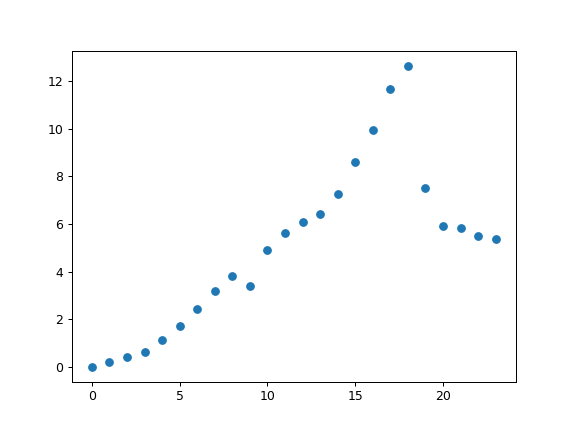

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook



model_chem = "B3LYP/def2-svp-dft-d3-Terachem"


scan_df = ds.df
scan_df = scan_df[scan_df[model_chem].notnull()]


init_energy = scan_df[model_chem].sort_index().iloc[0]
scan_df['rel_scan_energy'] = scan_df[model_chem] - init_energy
energy = scan_df['rel_scan_energy']
rx_coord =  [float(x) for x in scan_df.index]

plt.scatter(rx_coord, energy)

<html>
<center>
<br>
<h2> Send TS  computation for best candidates </h2>
<br><br>
</center>

## A) Define variables

In [ ]:
ts_candidate_id = 26150
ts_entry_name = 'ts1_02'
ts_from_neb_col_name = "salen_d-lac_ts_from_neb"

## B)  Create OptimizationDataset and/or load TS candidate from NEB

In [36]:
# Creat or load OptDataset for the ts optimization 
#ds_opt = ptl.collections.OptimizationDataset("test", client=client)
ds_opt = client.get_collection("OptimizationDataset", ts_from_neb_col_name)
ds_opt.status(collapse=False)

<OptimizationDataset(name=`salen_d-lac_ts_from_neb`, id='93', client='https://152.74.10.245:7778/') >

## C) Load candidate molecule from server

In [77]:
mol = client.query_molecules(ts_candidate_id)[0]
mol

NGLWidget()

## D) Add molecule to OptimizationDataset collection

In [78]:
#Add entry to the TS OptimizationDatas

ds_opt.add_entry("ts2_02", mol)
ds_opt.save()

'93'

## E)  Add specification for TS optmization with Terachem

This only needs to be done once but doing it again doesn't really hurt

In [79]:
kw = ptl.models.KeywordSet(**{"values": {"dftd": "d3", "convthre" : '3.0e-7', "threall" : '1.0e-13', 'dftgrid' : 2, "scf" : "diis+a"}})

kw_id = client.add_keywords([kw])[0]


add_spec = {'name':"b3lyp-d3_def2-svp",
        'description': 'Geometric + TERACHEM/b3lyp-d3/def2-svp.',
        'optimization_spec': {'program': 'geometric', 'keywords': {"transition": "yes", 
                                                                   "converge" :  ["set" , "gau_tight"]}},
        'qc_spec': {'driver': 'gradient',
        'method': "b3lyp",
        'basis': 'def2-svp',
        'keywords': kw_id,
        'program': 'terachem'}}
ds_opt.add_specification(**add_spec,overwrite=True)
ds_opt.save()

'93'

## F)  Send computations to the queue

In [80]:
cr = ds_opt.compute(specification = 'b3lyp-d3_def2-svp', tag='tera')#, subset=['HNO2', "HNO", 'HOCN', "N2O"])
cr

1

## G)  Check the status of the TS optimization

In [38]:
ds_opt = client.get_collection("OptimizationDataset", "salen_d-lac_ts_from_neb")
ds_opt.status(collapse = False)

,b3lyp-d3bj_def2-svp,b3lyp-d3_def2-svp
ts1_02,None,COMPLETE
ts1_02_G2,None,COMPLETE
ts1_02_G1,None,COMPLETE
ts1_03,None,COMPLETE
ts1_04,None,COMPLETE
ts2_02,None,COMPLETE
ts1_01,None,COMPLETE


## Extras

In [76]:
#Delte Entry 

#del ds_opt.data.records['ts2_02']
#ds_opt.save()

'93'

In [ ]:
#Delete Specification

#del ds_opt.data.specs['b3lyp-d3_def2-svp']
#ds_opt.save()